# Outline

This notebook complements the blog post and is intended to cover the following topics:
- Reproduce results/analysis, with code examples.
- Deep dive into results and errors from blog post.
- Instructions to score and analyze your own data.
- Misc discussion.

# Reproduce scoring results

## Setup


If you have cloned the repro and are running this locally, make sure you first follow setup in `tinydiarize/README.md`, particularly the section on the fstalign scoring tool. This notebook handles the rest of the setup (including downloading eval data).

> NOTE: If running on Google Colab - this notebook will fetch and use pre-computed results until we figure out how to get the fstalign scoring tool working on Colab.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython import display as ipd

In [2]:
if 'google.colab' in str(get_ipython()):
    # clone a particular branch of tinydiarize repo
    ! git clone https://github.com/akashmjn/tinyDiarize.git -b analysis-1 --single-branch
    # pip install
    ! pip install -e tinyDiarize
    # setup workdir
    WORKDIR = 'tinyDiarize/tinydiarize/workdir_analysis'
    CODEDIR = 'tinyDiarize/tinydiarize'
    _PRE_COMPUTED = True
else:
    # if running locally, assume that tinydiarize repo is already cloned and installed
    WORKDIR = '../workdir_analysis'
    CODEDIR = '..'
    _PRE_COMPUTED = False

ipd.clear_output()

## Evaluation data

We are using an out-of-distribution setup, evaluating on a different dataset than what the model was finetuned on (AMI meetings). As in Whisper, this allows us to get a more realistic estimate of real-world generalization vs the model's ability to fit dataset-specific quirks of the AMI dataset.

For ease of analysis (and keeping with the 'tiny' spirit 😊), I've chosen a biased subset of 3 earnings calls from [rev/earnings21](https://github.com/revdotcom/speech-datasets/blob/main/earnings21/earnings21-file-metadata.csv). These were selected with the following criteria:
- One interactive Q&A meeting (*939, Hershey) with a higher number of speaker switches and unique speakers
- One meeting (*910, Amex) that is a moderated Q&A between only 2 speakers
- One meeting (*971, Constellium) that comprises both a presentation and Q&A session, and is somewhere in between

| file_id | audio_length | company_name | sector | speaker_switches | speaker_switches / minute | unique_speakers |
|---------|--------------|--------------|--------|------------------|---------------------------|-----------------|
| 4385939 | 3049.832     | Hershey Company | Consumer Goods | 132 | 2.60 | 19 |
| 4374910 | 2028.536     | American Express Company | Financial | 56 | 1.66 | 2 |
| 4359971 | 3759.944     | Constellium | Industrial Goods | 116 | 1.85 | 10 |

In [3]:
# setup workdir structure and fetch evaluation data
if _PRE_COMPUTED:
    # download pre-computed results from blob
    ! wget -O {CODEDIR}/workdir_analysis.tar.gz https://sharedstorage7190.blob.core.windows.net/tinydiarize/precomputed/workdir_analysis-051923/4e95afe66042ca70b101bbe1f6fa24d648accaefc802cab6f36b2152f586b2e1.tar.gz
    # compute the SHA256 hash of the downloaded file
    ! echo "SHA256 hash of downloaded file: $(sha256sum {CODEDIR}/workdir_analysis.tar.gz)"
    # unpack pre-computed results into WORKDIR
    ! tar -xzf {CODEDIR}/workdir_analysis.tar.gz -C {CODEDIR}
else:
    ! mkdir -p {WORKDIR}
    # call a bash script with WORKDIR as an environment variable
    ! bash {CODEDIR}/scripts/fetch_earnings21_calls.sh {WORKDIR}

ipd.clear_output()

In [ ]:
# listen to an example file 
ipd.Audio(f'{WORKDIR}/audio/earnings21-4374910.mp3')

## Transcribing and scoring

We use a convenience script  to transcribe and score the calls. `run_pipelines.py` runs ASR (Whisper `small.en`) along with various diarization pipelines (explained in the following sections), scores them and parses detailed results into a single tsv file.

> *NOTE: On Google colab, we will fetch pre-computed results from my runs, as it's a bit tricky to setup the fstalign scoring tool*

In [ ]:
if not _PRE_COMPUTED:
    # change directory to ../scripts
    %cd {CODEDIR}/scripts

    # process all the selected calls
    calls = [
        ("earnings21-4385939", 19),
        ("earnings21-4374910", 2),
        ("earnings21-4359971", 10),
    ]

    # iterate over calls and run the script run_pipelines.py
    for call_id, num_speakers in calls:
        ! python run_pipelines.py {WORKDIR}/audio/{call_id}.mp3 {WORKDIR}/fstalign_scoring/references/{call_id}-ref.nlp {WORKDIR}/transcripts --num_speakers {num_speakers}

    # change directory back to ../notebooks
    %cd {CODEDIR}/notebooks


# Deep dive into results and errors

## Information on metrics

Diarization typically uses either time-based metrics (e.g. DER measures % of time correctly attributed) or transcript-based metrics that compare the final transcript. 

I prefer to use the latter as:
- It helps us see errors the way an end-user would i.e. [WYSIWYG](https://en.wikipedia.org/wiki/WYSIWYG).
- Analyzing errors in the semantic context of the conversation is much more intuitive than time-based metrics, and helps us quickly get a sense of where we really need to focus.
- Tricky edge cases such as disfluencies, speaker overlap, etc. can be handled in an interpretable way with the transcription convention (e.g. using special tokens for disfluencies, speaker overlap, and/or text normalization).

For our analysis here, we only score the "local" diarization sub-task of speaker segmentation (not the "global" task of clustering speakers across the entire meeting). We use the following metrics:
- WER: word error rate as measured by `fstalign`
- Speaker turn recall: the fraction of speaker changes that are correctly identified
- Speaker turn precision: the fraction of predicted speaker changes that are correct

Just like WER, speaker turn recall and precision are computed by aligning reference and hypothesis transcripts after inserting a special `speaker__turn` token, and then counting errors on the special tokens. We also parse the aligned ref/hyp transcripts for error analysis. *(see implementation in `score.py` for details)*

## Comparing results

We now compile all the TSV files generated by `run_pipelines.py` into a single dataframe for analysis. 

In [3]:
# some utility functions
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(CODEDIR)
from analysis_utils import compile_results, query_metric_results, plot_metric_results, inspect_errors

The dataframe contains both WER and speaker turn metrics along with a detailed error breakdown e.g. (DEL/INS/SUB) for WER, false negatives (DEL/SUB) for speaker turn recall, and false positives (INS/SUB) for speaker turn precision. 

We also parse the fstalign `*.sbs` alignment output to get the exact errors made by the model. This is useful for debugging and understanding the model's behavior.

In [4]:
results_df, analysis_results = compile_results(f"{WORKDIR}/fstalign_scoring/results")
results_df.head()

Read 84 results from 21 files
Read 21 side-by-side analysis results


,metric,value,denominator,numerator,deletions,insertions,substitutions,result_id,model,call_id,method
0,wer_overall,10.298820,9069,934,622,84,228,small.en__earnings21-4385939_drz_post_sr__segment,small.en,4385939,segment_timestamped_clustered
1,wer_speaker_switch,11.523046,998,115,68,11,36,small.en__earnings21-4385939_drz_post_sr__segment,small.en,4385939,segment_timestamped_clustered
2,spk_turn_precision,60.427811,187,113,0,64,10,small.en__earnings21-4385939_drz_post_sr__segment,small.en,4385939,segment_timestamped_clustered
3,spk_turn_recall,86.259544,131,113,16,0,2,small.en__earnings21-4385939_drz_post_sr__segment,small.en,4385939,segment_timestamped_clustered
0,wer_overall,12.876323,4916,633,353,68,212,small.en__earnings21-4374910_drz_pre_sr__segment,small.en,4374910,pyannote_pre_sr


We compare speaker turn recall/precision for the following:
- `punctuation`: Simple baseline that adds a speaker turn after every ending punctuation e.g. `.?!` created by whisper.transcribe. While precision will be low (not every punctuation is a speaker turn), the recall of this baseline helps us get a sense for how well the model is already implicitly marking speaker turns. The semantic context of a conversation is a strong signal for punctuations, so we'd expect it to help with speaker turns too.

- `pyannote_pre_sr`: Runs full pyannote diarization pipeline, and then whisper.transcribe on segments created by the pipeline, retaining the speakers assigned to each segment. This is a strong baseline with dedicated models running in a 2-stage process (segmentation + clustering). By looking through its errors, we can get a sense for what approaches of this kind (that run indepedently before ASR) are missing.

- `segment_timestamped`: Simple baseline that adds a speaker turn after every segment marked between whisper.transcribe timestamps (e.g. 00:27.080 --> 00:32.720 "this is a segment"). Similar to `punctuation`, the recall of this simple baseline helps get a sense for how well certain heuristics can do.

- `tdrz_token`: tinyDiarize model with a new `speaker_turn` token in the vocabulary that was finetuned on ~100hrs from the AMI meetings dataset prepared into long-form 30s chunks (see [tinydiarize/README.md](https://github.com/akashmjn/tinyDiarize/tree/main/tinydiarize) for details). These are decoded with the rest of tokens in whisper.transcribe. As we've created an explicit token for speaker turns, we'd expect this to have a much better precision than the `punctuation` baseline, with its recall as an upper bound. 

Note that our goal here is not necessarily to beat state of the art. Via this proof-of-concept, we aim to check the potential of an approach with a much simpler and efficient design. `tdrz_token` has essentially no extra cost at inference time *(overhead from decoding extra tokens is tiny)* and is easy to implement.

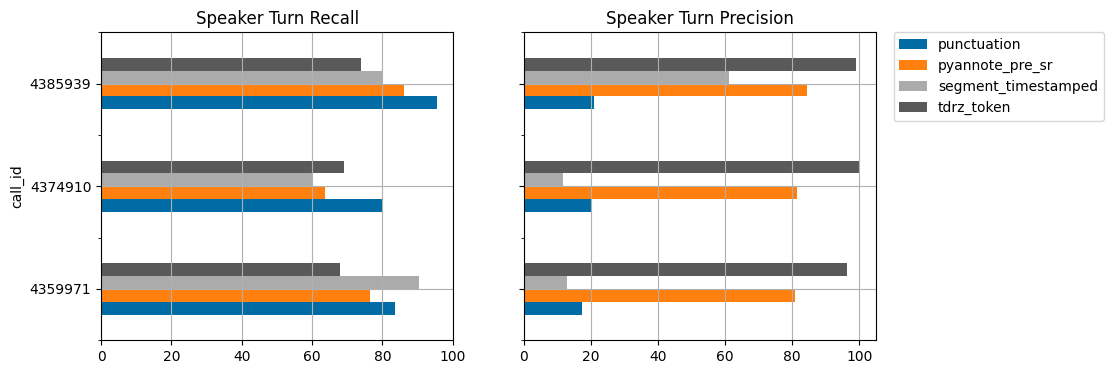

In [5]:
# comparing results for pyannote_pre_sr, time_segment, punctuation, token
subset_df = results_df.query('~(model=="small.en-tdrz" and method != "tdrz_token")')
subset_df = subset_df.query('method in ["punctuation", "pyannote_pre_sr", "segment_timestamped", "tdrz_token"]')
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
d1 = query_metric_results(subset_df, "spk_turn_recall", groups=["call_id", "method"])
plot_metric_results(d1, title="Speaker Turn Recall", ax=axes[0], legend=False)
d2 = query_metric_results(subset_df, "spk_turn_precision", groups=["call_id", "method"])
plot_metric_results(d2, title="Speaker Turn Precision", ax=axes[1])

We can make the following observations:
1. In terms of recall, the simple `punctuation` baseline does very well. This validates our hypothesis that the model already has a good implicit representation of speaker turns.
2. The `pyannote_pre_sr` pipeline has good overall performance, although it actually has a bit lower recall than the simple `punctuation` baseline. As we'll see in the next section this is primarily due to handling of short segments.
3. The `segment_timestamped` baseline is somewhat erratic. It either matches `punctuation` or has a big gap on `*910`. The quality of whisper timestamps is known to be a bit erratic, so this is not surprising.
4. The `tdrz_token` approach consistently gets near-perfect precision on all meetings, with a fairly decent recall. Given that we used a very simple & cheap finetuning setup, strong performance here indicates that we are indeed isolating representations that were implicitly present in the `punctuation` baseline.

Much like punctuations, as speaker turns have both acoustic and semantic cues, Whisper has a strong prior to do well at this task. In the next section, by manually inspecting errors, we'll see that this is also an advantage over conventional pre_pr diarization pipelines that only have access to acoustic cues.

## Error inspection

We now manually look through some examples to build intuition about what's going on and where bottlenecks lie. Our choice of transcript-based metrics (speaker turn precision/recall) allows us to do this in a very interpretable way.

TODO@Akash - clearly write down what we learned from this (LM & semantics, short segments, punctuation as a strong prior, etc.)

In [ ]:
# listen to an example file
call_id = "4385939"
ipd.Audio(f'{WORKDIR}/audio/earnings21-{call_id}.mp3')

### Recall errors

|Recall error type|pyannote_pre_sr|punctuation|tdrz_token|
|:----|:----|:----|:----|
|# false negatives (out of 131)|22|5|36|
|invalid|2|2|2|
|ASR deletion|7|3|11|
|short backchannel|13|0|10|
|other missed|0|0|13|

#### pyannote_pre_sr

Errors from the pyannote pipeline tend to be around short, few-word segments. From looking through examples, these are mostly backchannel responses that can occasionally involve partially overlapped speech. The errors are of two kinds - 

[TODO@Akash very wordy, can we simplify?]
- ASR errors: Whisper tends to skip over words, which may be exacerbated by transcribing chopped-up segments from the output of pyannote (some recent implementations run whisper as-is on long audio and use heuristics on timestamps to reconcile diarization results. However this too can get gnarly as it has to handle overlaps, missed words and other edge cases). 

- Pyannote under-segmentation errors: Due to design limitations discussed in the blog post, conventional pipelines have to trade-off temporal resolution with accuracy. This is clearly reflected in the errors we see below, where short segments were likely merged into longer ones either during segmentation or clustering.

In [9]:
# notes on errors: TODO@Akash - redo after rerun
# 0,7,8,10,11,12,16 - DEL
# 1,2,3,6,9,13,14,15,19,20,21,17,18 - miss short backchannel, 17/18 involve ASR errors
# 4,5 - invalid inaudible
inspect_errors(results_df, analysis_results, ("small.en", call_id, "pyannote_pre_sr"), recall_errors=[16,17])

Results for: ('small.en', '4385939', 'pyannote_pre_sr')


,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,13.468125,9051,1219,603,153,463
1,wer_speaker_switch,23.547094,998,235,70,63,102
2,spk_turn_precision,84.328362,134,113,0,18,3
3,spk_turn_recall,86.259544,131,113,14,0,4


Precision errors: 21
Recall errors: 18

 ---------- Recall errors: ----------

Line: 7381, Index: 16
              thanks	thanks              			
                 for	for                 			
                 the	the                 			
            question	question            			
       speaker__turn	<del>               	ERR		
                good	<del>               	ERR		
             morning	<del>               	ERR		
       speaker__turn	<del>               	ERR		
                good	the                 	ERR		
             morning	one                 	ERR		
       speaker__turn	you                 	ERR	___101_SPEAKER_TURN___	101|
                  um	wanted              	ERR		
             michele	michelle            	ERR		
                   i	i                   			
                like	like                			
                  to	to                  			
              follow	follow              			
                  up	up                  			
                  on	on             

Manually reading through the transcripts, even without listening to the audio, we can clearly identify these short segments as speaker turns. 

Semantic context is particularly important for short segments like these, where conventional pre_sr pipelines like pyannote introduce errors due to lack of context (only available during/after ASR).

#### punctuation

Meanwhile, the punctuation baseline did not miss these short segments. From inspection below we see that all the remaining errors are actually ASR errors, where whisper skipped over some backchannel words. 

This means that (for the words actually recognized) Whisper almost always correctly demarcates different speakers by placing punctuations at the right place.

In [144]:
# notes on recall errors: TODO@Akash - redo after rerun
# 0,4 - invalid nonverbal
# 1,2,3 - DEL
inspect_errors(results_df, analysis_results, ("small.en", call_id, "punctuation"), recall_errors=[1,2])

Results for: ('small.en', '4385939', 'punctuation')


,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,10.183142,9064,923,601,84,238
1,wer_speaker_switch,12.925851,998,129,76,17,36
2,spk_turn_precision,24.324326,518,126,0,271,121
3,spk_turn_recall,96.183205,131,126,4,0,1


Precision errors: 392
Recall errors: 5

 ---------- Recall errors: ----------

Line: 3995, Index: 1
                very	<del>               	ERR		
                much	<del>               	ERR		
       speaker__turn	speaker__turn       			
                 and	and                 			
               jason	jason               			
                it's	<del>               	ERR		
             melissa	<del>               	ERR		
                 one	one                 			
               other	other               			
               thing	thing               			
       speaker__turn	<del>               	ERR	___50_SPEAKER_TURN___	###50_###|
                sure	<del>               	ERR		
       speaker__turn	<del>               	ERR		
                  to	to                  			
                just	just                			
                keep	keep                			
                  in	in                  			
                mind	mind                			
               <ins>	speaker__turn    

#### tdrz_token

TODO@Akash - add analysis

In [161]:
# notes on recall errors: # TODO@Akash - redo after rerun
# 0,1,14,18,21,25,26,30,31,34,35 - miss
# 5,7,15,16,17,19,20,24,28,29,32,33 - miss short backchannel
# 2,3,4,8,9,10,11,12,13,22,23 - DEL
# 6,27 - invalid nonverbal
# inspect_errors(results_df, analysis_results, ("small.en-tdrz", call_id, "tdrz_token"), recall_errors=[0,30])
inspect_errors(results_df, analysis_results, ("small.en-tdrz", call_id, "tdrz_token"), recall_errors=[6,7,27,28])

Results for: ('small.en-ft', '4385939', 'tdrz_token')


,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,7.498897,9068,680,83,228,369
1,wer_speaker_switch,11.422846,998,114,27,31,56
2,spk_turn_precision,98.958328,96,95,0,1,0
3,spk_turn_recall,72.519081,131,95,30,0,6


Precision errors: 1
Recall errors: 36

 ---------- Recall errors: ----------

Line: 3240, Index: 6
               could	could               			
                also	also                			
                 you	you                 			
                know	know                			
           gravitate	gravitate           			
                  to	to                  			
                 the	the                 			
             holiday	holiday             			
              pretty	pretty              			
             quickly	quickly             			
       speaker__turn	<del>               	ERR	___37_SPEAKER_TURN___	###37_###|
         <inaudible>	<del>               	ERR		
       speaker__turn	<del>               	ERR		
                   a	a                   			
              strong	strong              			
           halloween	halloween           			
               <ins>	sell                	ERR		
               <ins>	through             	ERR		
               <ins>	yeah                	ERR

### Precision errors

Here too we see errors involving oversegmentation of short segments. Those mostly comprise of falsely creating extra segments that are either duplicated or overlapped with the main content, with a small over-segmenting/splitting an existing segment.

|Precision error type|pyannote_pre_sr|tdrz_token|
|:----|:----|:----|
|# predictions|130|96|
|# false positives|21|1|
|short extra segment|17|1|
|other extra segment|3|-|
|over segment|1|-|

In [169]:
# notes on precision errors: # TODO@Akash - redo after rerun
# 0,3,4,5,6*,7,9,10,11,13,16,17,18,19 - short extra segment, 8/14/15 have duplicated words
# 1,2,20 - extra segment 
# 12 - oversegment
inspect_errors(results_df, analysis_results, ("small.en", call_id, "pyannote_pre_sr"), precision_errors=[2, 6])

Results for: ('small.en', '4385939', 'pyannote_pre_sr')


,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,14.317279,9052,1296,606,174,516
1,wer_speaker_switch,24.849699,998,248,69,63,116
2,spk_turn_precision,83.846153,130,109,0,18,3
3,spk_turn_recall,83.206108,131,109,16,0,6


Precision errors: 21
Recall errors: 22

 ---------- Precision errors: ----------

Line: 3330, Index: 2
               going	going               			
             forward	forward             			
               <ins>	speaker__turn       	ERR		
               <ins>	leave               	ERR		
                  um	that                	ERR		
                 the	the                 			
               <ins>	ventilator          	ERR		
               <ins>	at                  	ERR		
               <ins>	any                 	ERR		
               <ins>	point..             	ERR		
               <ins>	speaker__turn       	ERR		
               <ins>	the                 	ERR		
           halloween	halloween           			
               early	early               			
                part	heart               	ERR		
             selling	cellin              	ERR		
                 was	was                 			
               <ins>	phenomenal          	ERR		
        phenomenally	it's                	ERR		
   

In [10]:
# 0 - short extra segment
inspect_errors(results_df, analysis_results, ("small.en-tdrz", call_id, "tdrz_token"))

Results for: ('small.en-tdrz', '4385939', 'tdrz_token')


,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,7.543008,9068,684,85,232,367
1,wer_speaker_switch,11.923847,998,119,31,32,56
2,spk_turn_precision,98.979591,98,97,0,1,0
3,spk_turn_recall,74.045799,131,97,29,0,5


Precision errors: 1
Recall errors: 34


### Conclusion 

`TODO@Akash` - complete this

# Score and analyze your own data 

To do so, you will need to:
- Replace files under `WORKDIR/audio` with your own audio files
- Create reference files in the [fstalign NLP format](https://github.com/revdotcom/fstalign/blob/develop/docs/NLP-Format.md]) under `WORKDIR/fstalign_scoring/references` 
- Make sure that the NLP contains speaker IDs in column 2. These are only used to score speaker turns. If your transcript only has speaker turns without global IDs, you can just increment a dummy speaker ID after every turn.

Once this is done, you can simply plug it in to the `run_pipelines.py` script as above.

# Misc discussion

`TODO@Akash` - clean up rough notes here and complete end section

- comparison of WER from pre_sr segmentation and after finetuning
- comparison of runtime between pyannote, tinydiarize and time_segment_clustered
- discussion of integration with clustering via post_sr results

### WER comparison and impact of fine-tuning

We can see that naively altering the segments in `drz_pre_sr` can have a significant (15%+ relative) negative impact on the WER. In regions around speaker switches the impact is much higher (40-70%), as segments tend to be much shorter here.

In [ ]:
subset_df = results_df.query('method in ["pyannote_pre_sr", "time_segment"]')
print("WER impact of finetuning")
ipd.display(query_metric_results(subset_df.query('method=="time_segment"'), "wer_overall", groups=["call_id", "model"]))
# we see that after finetuning, the overall WER not impacted too much
print("WER impact of segmentation in pyannote_pre_sr")
ipd.display(query_metric_results(subset_df, "wer_overall", groups=["call_id", "method"]))
# ipd.display(query_metric_results(subset_df, "wer_speaker_switch", groups=["call_id", "method"]))
# pre-segmented recognition hurts WER, especially around speaker switches

WER impact of finetuning


model,small.en,small.en-ft
call_id,,
4359971,13.03,13.89
4374910,10.14,6.91
4385939,10.18,7.50


WER impact of segmentation in pyannote_pre_sr


method,pyannote_pre_sr,time_segment
call_id,,
4359971,19.58,13.03
4374910,13.71,6.91
4385939,14.32,7.50


I've also noticed these undesirable regressions/gotchas. The regressions are fixable with more modular and careful finetuning.
- the finetuned model spkturn_segments has significantly lower recall from ~ 80% -> 10%. probably because of training on a different (longer) distribution of segments in ami data. or that the model simply forgets to output timestamps
- WER is quite different, some better or worse, with very different sub/ins/del pattern

### Runtime comparison

### Discussion on adding clustering

how to retain advantages?

looking closer we see why (insert nemo graphic on fidelity vs temporal resolution). this tradeoff comes at a significant extra cost (already quite expensive). even so, it is a patch on a fundamental drawback. SR models can easiliy output tokens at much higher time resolution, making it a much more natural choice. 
this will only yield local (within 30s chunk) - will still need a clustering process to group speakers across full timescale of meeting.

- gap in recall between drz_post_sr and segment            (indicates ?)
- gap in precision errors for post sr on 9971 inspite of higher recall?  (indicates clustering errors)

overall, the gap between segment and drz_post_sr shows a lot of clustering errors. 

Summary:
- the model makes very few spk turn predictions but with ~100% precision. these are likely already included within punctuations (should check if these were missed by time segments, or diarization)
- `drz_post_sr` clustering will still be needed. hope is that `speaker_turn` is predicted well difficult parts (short segments) acting in a complementary way to further improve clustering recall errors. to enable `drz_post_sr`, i need to modify decoding to force sample a timestamp when token is predicted
- since the model tends to be very precise, another `speaker_same` token could also help clustering precision errors, so that short segments still get assigned to the same speaker when there are larger # of speakers. in this case we'd skip sampling a timestamp to make a longer segment